Desafio redes neurais, Gustavo Alves

Dataset: Stellar Classification (link: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Vamos olhar como nosso dataset se parece:

In [121]:
df = pd.read_csv("archive/star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


---
Questão 1)

---

a) Criar uma rede neural de classificação entre galáxias, quasares e estrelas
usando Tensorflow ou Pytorch

Antes de criar nossa rede neural, vamos fazer uma análise dos dados:

Primeiro, vamos ver com qual tipo de dados estamos lidando

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [123]:
df.describe().round(2)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.0,100000.00,100000.00,1.000000e+05,100000.00,100000.00,100000.00,100000.00
mean,1.237665e+18,177.63,24.14,21.98,20.53,19.65,19.08,18.67,4481.37,301.0,3.51,186.13,5.783882e+18,0.58,5137.01,55588.65,449.31
std,8.438560e+12,96.50,19.64,31.77,31.75,1.85,1.76,31.73,1964.76,0.0,1.59,149.01,3.324016e+18,0.73,2952.30,1808.48,272.50
min,1.237646e+18,0.01,-18.79,-9999.00,-9999.00,9.82,9.47,-9999.00,109.00,301.0,1.00,11.00,2.995191e+17,-0.01,266.00,51608.00,1.00
25%,1.237659e+18,127.52,5.15,20.35,18.97,18.14,17.73,17.46,3187.00,301.0,2.00,82.00,2.844138e+18,0.05,2526.00,54234.00,221.00
50%,1.237663e+18,180.90,23.65,22.18,21.10,20.13,19.41,19.00,4188.00,301.0,4.00,146.00,5.614883e+18,0.42,4987.00,55868.50,433.00
75%,1.237668e+18,233.90,39.90,23.69,22.12,21.04,20.40,19.92,5326.00,301.0,5.00,241.00,8.332144e+18,0.70,7400.25,56777.00,645.00
max,1.237681e+18,360.00,83.00,32.78,31.60,29.57,32.14,29.38,8162.00,301.0,6.00,989.00,1.412694e+19,7.01,12547.00,58932.00,1000.00


In [124]:
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [125]:
df.shape

(100000, 18)

Temos 18 variáveis no total, distribuídas entre 100000 linhas, sendo elas:

1) 7 variáveis numéricas discretas: obj_ID, run_ID, rerun_ID, cam_col, plate, MJD, field_ID

2) 9 variáveis numéricas contínuas: alpha, delta, u, g, r, i, z, spec_obj_ID, redshift

3) 1 variável de classificação: class, que pode ser um desses 3 valores: [GALAXY, STAR, QSO]

Ao ver a descrição dos nossos dados, algumas coisas chamam atenção:

1) Várias colunas tem 'ID' no nome, que normalmente se refere à uma coluna de enumeração de itens. Se for o caso, devemos remove-lás, nossa análise deve basear-se em parâmetros físicos dos objetos;

2) Os parâmetros 'u','g' e 'z' tem mínimos bem distintos da média e de valores contidos nos outros quantis, possivelmente um outlier;


De acordo com o site de análise do dataset(https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17/data), as variáveis estão definidas da seguinte forma:


1) obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2) alpha = Right Ascension angle (at J2000 epoch)
3) delta = Declination angle (at J2000 epoch)
4) u = Ultraviolet filter in the photometric system
5) g = Green filter in the photometric system
6) r = Red filter in the photometric system
7) i = Near Infrared filter in the photometric system
8) z = Infrared filter in the photometric system
9) run_ID = Run Number used to identify the specific scan
10) rerun_ID = Rerun Number to specify how the image was processed
11) cam_col = Camera column to identify the scanline within the run
12) field_ID = Field number to identify each field
13) spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14) class = object class (galaxy, star or quasar object)
15) redshift = redshift value based on the increase in wavelength
16) plate = plate ID, identifies each plate in SDSS
17) MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18) fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


Notoriamente, as colunas das variáveis de 'ID' não tem informações físicas importantes para nós, apenas servem para enumeração do objeto, da câmera, entre outros objetos. Além disso, as variáveis 'plate' e 'MJD' também não são variáveis físicas, são apenas rótulos arbritários, não faz sentido incluir eles. Por exemplo: se nosso algoritmo entendesse que em uma certa data, que é o parâmetro 'MJD', a classificação é de quasar, não significa que há uma relação, apenas que as observações daquele dia foram e quasares. Incluir essas features não será de ajuda para nós.

In [126]:

df_numeric = df.copy()
df_numeric.drop(columns=['obj_ID', 'run_ID', 'rerun_ID','cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'], axis=1, inplace=True)
df_numeric['class'] = pd.Categorical(df['class']).codes

df_numeric.head().round(2)

,alpha,delta,u,g,r,i,z,class,redshift
0,135.69,32.49,23.88,22.28,20.40,19.17,18.79,0,0.63
1,144.83,31.27,24.78,22.83,22.58,21.17,21.61,0,0.78
2,142.19,35.58,25.26,22.66,20.61,19.35,18.95,0,0.64
3,338.74,-0.40,22.14,23.78,21.61,20.50,19.25,0,0.93
4,345.28,21.18,19.44,17.58,16.50,15.98,15.54,0,0.12


In [127]:
df_numeric.describe().round(2)

,alpha,delta,u,g,r,i,z,class,redshift
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,177.63,24.14,21.98,20.53,19.65,19.08,18.67,0.62,0.58
std,96.50,19.64,31.77,31.75,1.85,1.76,31.73,0.82,0.73
min,0.01,-18.79,-9999.00,-9999.00,9.82,9.47,-9999.00,0.00,-0.01
25%,127.52,5.15,20.35,18.97,18.14,17.73,17.46,0.00,0.05
50%,180.90,23.65,22.18,21.10,20.13,19.41,19.00,0.00,0.42
75%,233.90,39.90,23.69,22.12,21.04,20.40,19.92,1.00,0.70
max,360.00,83.00,32.78,31.60,29.57,32.14,29.38,2.00,7.01


Agora que selecionamos melhor nossas features, vamos ver se temos dados faltantes e depois tratar os outliers:

In [128]:
df.isna().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

Percebe-se que temos um dataset sem dados faltantes, com 100000 linhas de dados ao todo. Por último, vamos detectar se temos outliers nesses dados utilizando os quantis:

In [129]:
for col in df_numeric:

    Q1 = df_numeric[col].quantile(0.25)
    Q3 = df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    filtro = (df_numeric[col] >= limite_inferior) & (df_numeric[col] <= limite_superior)
    print(f"Outliers na coluna {col}: {100000 - filtro.sum()}")


Outliers na coluna alpha: 0
Outliers na coluna delta: 0
Outliers na coluna u: 56
Outliers na coluna g: 99
Outliers na coluna r: 132
Outliers na coluna i: 198
Outliers na coluna z: 320
Outliers na coluna class: 0
Outliers na coluna redshift: 8990


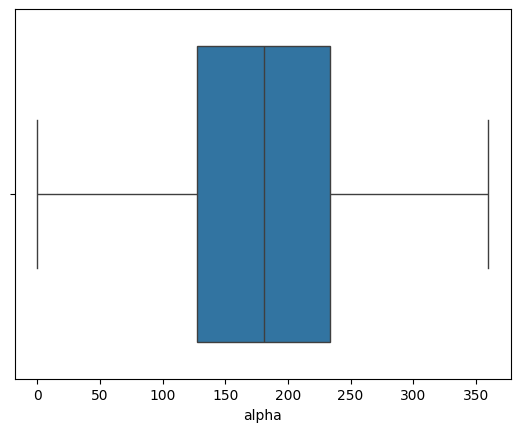

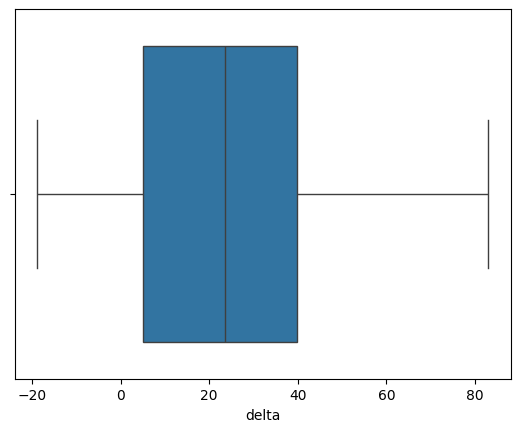

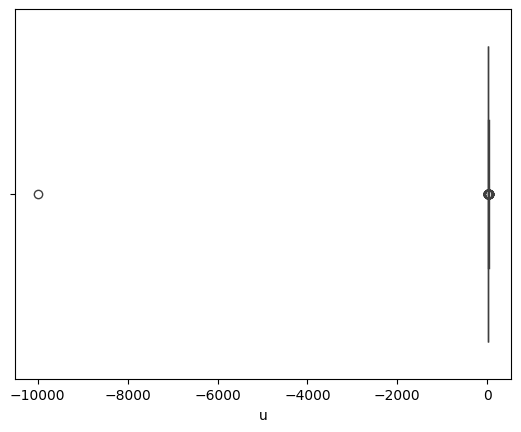

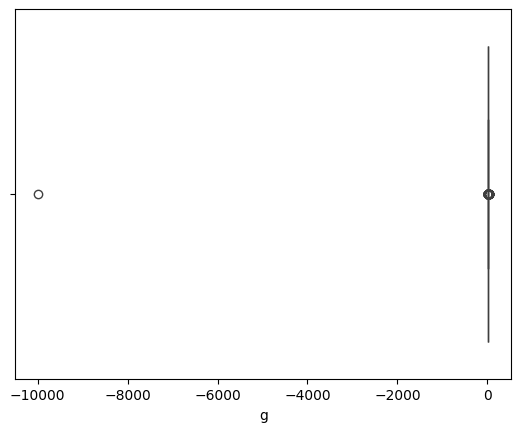

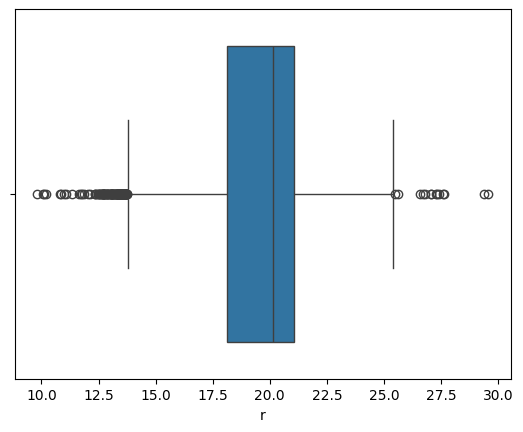

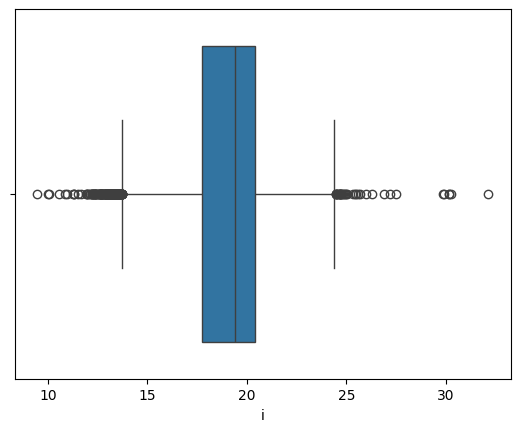

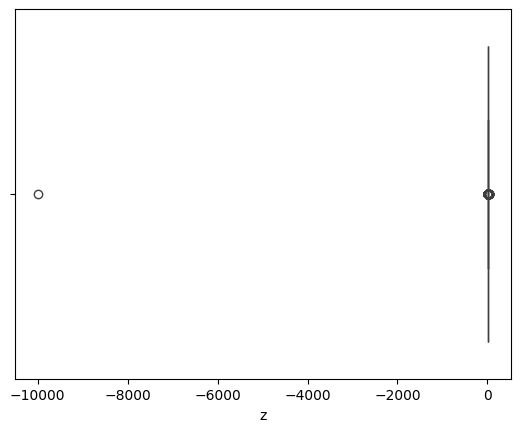

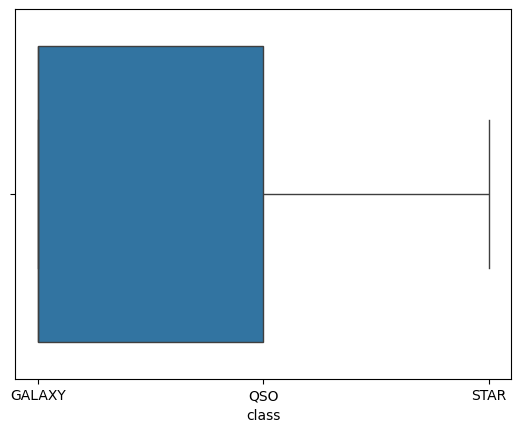

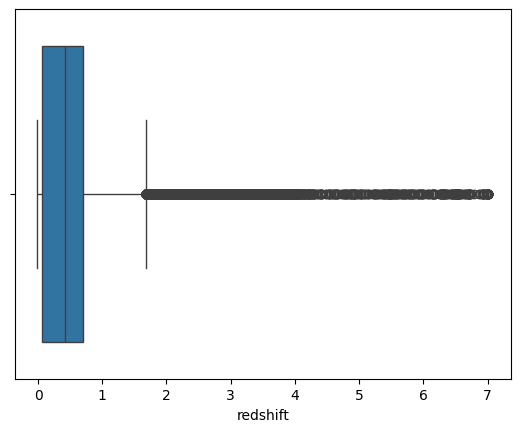

In [130]:
for col in df_numeric:
    sns.boxplot(x=df[col])
    plt.show()

Olhado os gráficos , os únicos outliers que eu vejo como necessários de remoção são aqueles mínimos extremos já citados em ['u', 'g' e 'z']. Os outros outliers, apesar de serem numerosos no caso do redshift, ainda tem um intervalo próximo da média das outras medições então manterei.

In [131]:
colunas_outlier_minimo = ['u', 'g', 'z']

for col in colunas_outlier_minimo:
    print(f"{col}: valores < -9000 =", (df_numeric[col] < -9000).sum())
    df_numeric = df_numeric[df_numeric[col] >= -9000]    

u: valores < -9000 = 1
g: valores < -9000 = 0
z: valores < -9000 = 0


In [132]:
df_numeric.describe()

,alpha,delta,u,g,r,i,z,class,redshift
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,0.621476,0.576667
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,0.816771,0.730709
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,0.000000,-0.009971
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,0.000000,0.054522
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,0.000000,0.424176
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,1.000000,0.704172
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,2.000000,7.011245


Finalmente, agora com a análise de dados exploratória feita, vamos definir nosso primeiro modelo de rede neural!

Para esse modelo, escolhi os seguintes parâmetros:

1) 3 camadas, 2 de ativação regressão linear positiva, 1 de ativação softmax para a saída, contendo 8, 64 e 3 neurônios respectivamente
2) Otimização Adam
3) Perda entropia cruzada

In [133]:
X = df_numeric.drop(['class'], axis=1)
y = df_numeric['class']

le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test,  y_test, verbose=2)


Epoch 1/10


/home/new-fring/Documentos/analise_dados/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 788us/step - accuracy: 0.5728 - loss: 1.4997
Epoch 2/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 698us/step - accuracy: 0.7617 - loss: 0.5574
Epoch 3/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 702us/step - accuracy: 0.8736 - loss: 0.3198
Epoch 4/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step - accuracy: 0.9021 - loss: 0.2693
Epoch 5/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 791us/step - accuracy: 0.9215 - loss: 0.2258
Epoch 6/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step - accuracy: 0.9300 - loss: 0.2084
Epoch 7/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step - accuracy: 0.9401 - loss: 0.1868
Epoch 8/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.9378 - loss: 0.1938
Epoch 9/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step - accuracy: 0.9375 - loss: 0.1864
Epoch 10/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 710us/step - accuracy: 0.9419 - loss: 0.1802
782/782 - 1s - 791us/step - accuracy: 0.9338 - loss: 0.1977


[0.19765295088291168, 0.9338399767875671]

Tivemos um alto desempenho! Para confirmar isso, vamos gerar uma matriz de confusão e analisar:

---

b. Testar o efeito de se variar a largura e a profundidade da rede neural;

Primeiramente, vamos aumentar a largura, adicionando camadas extras de 63 neurônios:

In [134]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test,  y_test, verbose=2)

Epoch 1/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 751us/step - accuracy: 0.6035 - loss: 1.1787
Epoch 2/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 737us/step - accuracy: 0.7504 - loss: 0.5863
Epoch 3/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step - accuracy: 0.8278 - loss: 0.3991
Epoch 4/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step - accuracy: 0.8854 - loss: 0.2921
Epoch 5/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.9072 - loss: 0.2521
Epoch 6/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.9101 - loss: 0.2471
Epoch 7/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 706us/step - accuracy: 0.9162 - loss: 0.2325
Epoch 8/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 788us/step - accuracy: 0.9281 - loss: 0.2129
Epoch 9/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 764us/step - accuracy: 0.9270 - loss: 0.2120
Epoch 10/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 752us/step - accuracy: 0.9273 - loss: 0.2105
782/782 - 1s - 685us/step - accuracy: 0.8084 - loss: 0.4920


[0.4920312166213989, 0.8084400296211243]

Agora, vamos aumentar a profundidade:

In [117]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test,  y_test, verbose=2)

Epoch 1/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 692us/step - accuracy: 0.6100 - loss: 1.1412
Epoch 2/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 842us/step - accuracy: 0.7728 - loss: 0.5291
Epoch 3/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 803us/step - accuracy: 0.8705 - loss: 0.3300
Epoch 4/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 786us/step - accuracy: 0.9110 - loss: 0.2594
Epoch 5/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.9182 - loss: 0.2490
Epoch 6/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 783us/step - accuracy: 0.9212 - loss: 0.2383
Epoch 7/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 738us/step - accuracy: 0.9263 - loss: 0.2284
Epoch 8/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step - accuracy: 0.9239 - loss: 0.2295
Epoch 9/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 913us/step - accuracy: 0.9298 - loss: 0.2165
Epoch 10/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step - accuracy: 0.9340 - loss: 0.1999
782/782 - 1s - 726us/step - accuracy: 0.9370 - loss: 0.1759


[0.17593583464622498, 0.9370399713516235]

Curiosamente, aumentar a largura da nossa rede neural não ajudou nosso algoritmo, provavelmente porque nós precisariamos de mais epochs para alcançar um resultado desejado. Por outro lado, aumentar a profundidade manteve o mesmo desempenho, provavelmente com mais epochs teríamos um resultado melhor.

---
c. Treine o modelo testando diferentes valores de épocas e learning rate,
identificando quando se acontece Overfitting ou Underfitting;

In [137]:
epochs = [1, 3, 5, 10, 15, 30, 50, 100]
adams = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
avaliacao = []

for e in epochs:
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=e)
    avaliacao.append(model.evaluate(X_test,  y_test, verbose=2))
    
print(avaliacao)

/home/new-fring/Documentos/analise_dados/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - accuracy: 0.5611 - loss: 1.7057
782/782 - 1s - 797us/step - accuracy: 0.7410 - loss: 0.6017
Epoch 1/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 647us/step - accuracy: 0.6285 - loss: 1.0399
Epoch 2/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.7559 - loss: 0.5783
Epoch 3/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 657us/step - accuracy: 0.7753 - loss: 0.5336
782/782 - 1s - 850us/step - accuracy: 0.7946 - loss: 0.5153
Epoch 1/5
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 837us/step - accuracy: 0.5610 - loss: 1.5887
Epoch 2/5
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 776us/step - accuracy: 0.7358 - loss: 0.6264
Epoch 3/5
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step - accuracy: 0.7934 - loss: 0.4784
Epoch 4/5
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.8842 - loss: 0.2961
Epoch 5/5
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 751us/step - accuracy: 0.9142 - loss: 0.2378
782/782 - 1s - 747us/step - accuracy: 0.8930 - loss: 0.2448
Epoch 1/10
2344/2344 ━━━━━━━━